# Data Preprocessing Notebook
## Handling Imbalanced Data and Feature Extraction

In [1]:
# Import required libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.utils import resample
from sklearn.feature_extraction.text import TfidfVectorizer
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
import sys
import os

# Add src to path
sys.path.append('../src')
from data_preprocessing import DataPreprocessor

# Set style for plots
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")

## 1. Load and Explore Original Data

Loading original dataset...
Original dataset shape: (15470978, 20)

Dataset info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15470978 entries, 0 to 15470977
Data columns (total 20 columns):
 #   Column                Dtype  
---  ------                -----  
 0   Unnamed: 0            int64  
 1   level_0               int64  
 2   index                 int64  
 3   Description           object 
 4   Type                  object 
 5   Pattern               object 
 6   Code                  object 
 7   Severity              object 
 8   Input Case            object 
 9   CVSS                  float64
 10  CWE_ID                object 
 11  CWE_Desc              object 
 12  OWASP_Mobile          object 
 13  OWSAP_MASVS           object 
 14  Reference             object 
 15  Vulnerability_status  int64  
 16  processed_code        object 
 17  category              object 
 18  qark_name             object 
 19  severity              object 
dtypes: float64(1), int64(4), obj

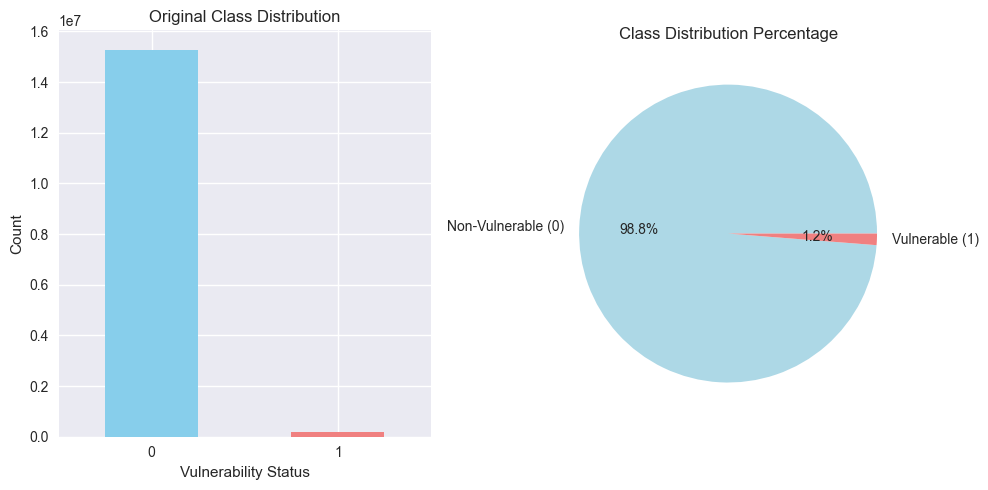


Imbalance Ratio: 79.60:1


In [3]:
# Load original dataset
print("Loading original dataset...")
original_df = pd.read_csv('../data/LVDAndro_APKs_Combined_Processed.csv', low_memory=False)

print(f"Original dataset shape: {original_df.shape}")
print("\nDataset info:")
print(original_df.info())

# Check class distribution
print("\nOriginal class distribution:")
class_dist = original_df['Vulnerability_status'].value_counts()
print(class_dist)

# Plot class distribution
plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
class_dist.plot(kind='bar', color=['skyblue', 'lightcoral'])
plt.title('Original Class Distribution')
plt.xlabel('Vulnerability Status')
plt.ylabel('Count')
plt.xticks(rotation=0)

plt.subplot(1, 2, 2)
plt.pie(class_dist.values, labels=['Non-Vulnerable (0)', 'Vulnerable (1)'], 
        autopct='%1.1f%%', colors=['lightblue', 'lightcoral'])
plt.title('Class Distribution Percentage')

plt.tight_layout()
plt.show()

# Calculate imbalance ratio
imbalance_ratio = class_dist[0] / class_dist[1]
print(f"\nImbalance Ratio: {imbalance_ratio:.2f}:1")

## 2. Handle Imbalanced Data

Handling imbalanced data through downsampling...
Loading and balancing dataset...
Original dataset shape: (15470978, 20)
Balanced dataset shape: (383898, 20)
Class distribution after balancing:\n0    191949
1    191949
Name: Vulnerability_status, dtype: int64

Balanced dataset saved to '../data/LVDAndro_APKs_downsampled.csv'


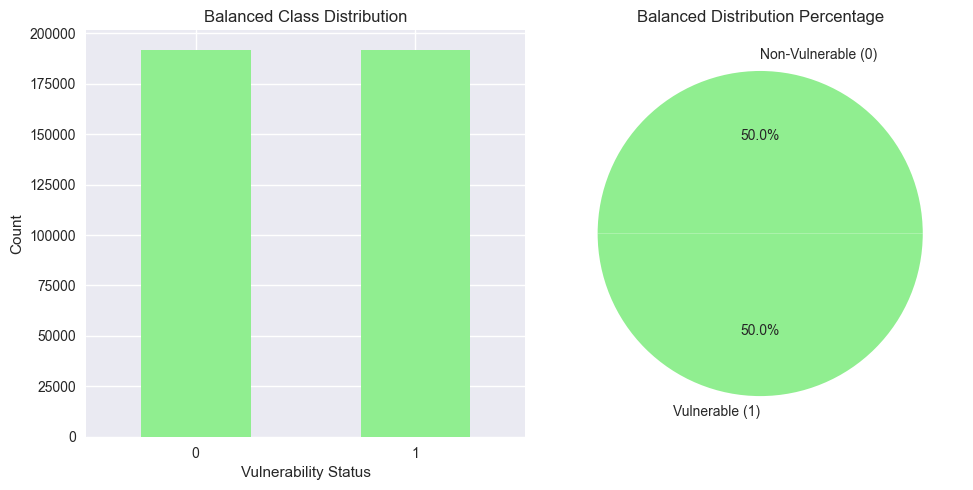


Comparison Summary:
Original dataset size: 15,470,978
Balanced dataset size: 383,898
Reduction: 97.5%


In [4]:
# Initialize preprocessor
preprocessor = DataPreprocessor(random_state=42)

# Handle imbalanced data
print("Handling imbalanced data through downsampling...")
balanced_df = preprocessor.handle_imbalanced_data(
    '../data/LVDAndro_APKs_Combined_Processed.csv'
)

# Save balanced dataset
balanced_df.to_csv('../data/LVDAndro_APKs_downsampled.csv', index=False)
print("\nBalanced dataset saved to '../data/LVDAndro_APKs_downsampled.csv'")

# Visualize balanced distribution
balanced_dist = balanced_df['Vulnerability_status'].value_counts()

plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
balanced_dist.plot(kind='bar', color=['lightgreen', 'lightgreen'])
plt.title('Balanced Class Distribution')
plt.xlabel('Vulnerability Status')
plt.ylabel('Count')
plt.xticks(rotation=0)

plt.subplot(1, 2, 2)
plt.pie(balanced_dist.values, labels=['Non-Vulnerable (0)', 'Vulnerable (1)'], 
        autopct='%1.1f%%', colors=['lightgreen', 'lightgreen'])
plt.title('Balanced Distribution Percentage')

plt.tight_layout()
plt.show()

# Compare before and after
print("\nComparison Summary:")
print(f"Original dataset size: {len(original_df):,}")
print(f"Balanced dataset size: {len(balanced_df):,}")
print(f"Reduction: {((len(original_df) - len(balanced_df)) / len(original_df) * 100):.1f}%")

## 3. Explore Balanced Data

Sample of balanced dataset:
   Unnamed: 0  level_0    index  \
0     3219442  3858416   688890   
1     1590806  1590806  1659842   
2     5610414  6636928  1961829   
3     7338561  8424774  3759936   
4     3775837  4608911   177495   

                                         Description   Type  \
0                                                NaN    NaN   
1                                                NaN    NaN   
2  The App logs information. Sensitive informatio...  Regex   
3  The App logs information. Sensitive informatio...  Regex   
4                                                NaN    NaN   

                                             Pattern  \
0                                                NaN   
1                                                NaN   
2  Log\.(v|d|i|w|e|f|s)|System\.out\.print|System...   
3  Log\.(v|d|i|w|e|f|s)|System\.out\.print|System...   
4                                                NaN   

                                             

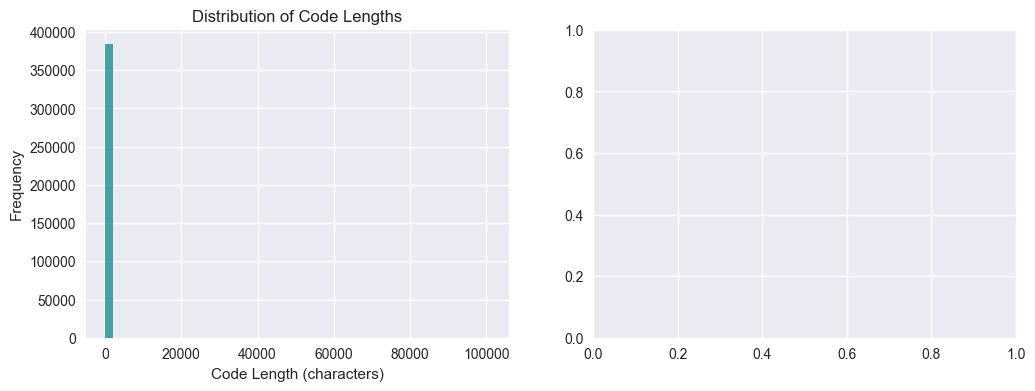

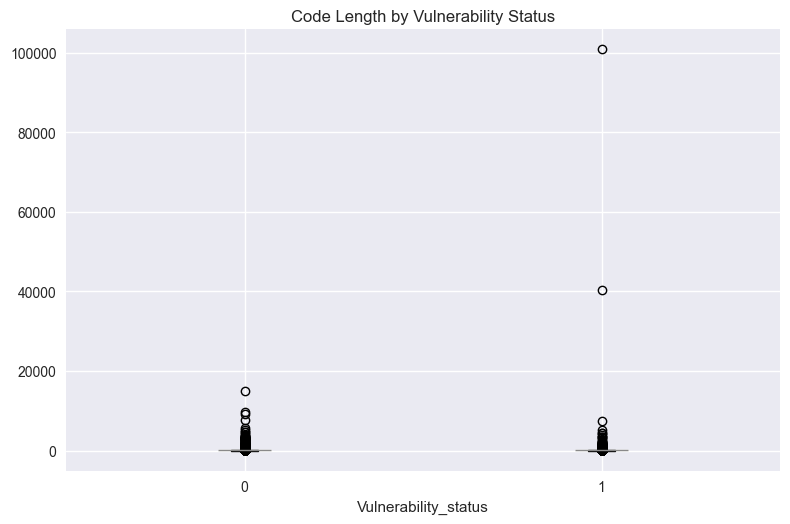


Code length statistics:
Mean code length: 56.94 characters
Median code length: 48.00 characters
Max code length: 100787.00 characters


In [5]:
# Display sample of balanced data
print("Sample of balanced dataset:")
print(balanced_df.head())

# Check for missing values
print("\nMissing values in balanced dataset:")
print(balanced_df.isnull().sum())

# Basic statistics
print("\nBasic statistics:")
print(balanced_df.describe())

# Check processed code length distribution
balanced_df['code_length'] = balanced_df['processed_code'].astype(str).apply(len)

plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
balanced_df['code_length'].hist(bins=50, alpha=0.7, color='teal')
plt.title('Distribution of Code Lengths')
plt.xlabel('Code Length (characters)')
plt.ylabel('Frequency')

plt.subplot(1, 2, 2)
balanced_df.boxplot(column='code_length', by='Vulnerability_status')
plt.title('Code Length by Vulnerability Status')
plt.suptitle('')  # Remove automatic title

plt.tight_layout()
plt.show()

print(f"\nCode length statistics:")
print(f"Mean code length: {balanced_df['code_length'].mean():.2f} characters")
print(f"Median code length: {balanced_df['code_length'].median():.2f} characters")
print(f"Max code length: {balanced_df['code_length'].max():.2f} characters")

## 4. Feature Extraction

Extracting TF-IDF features...
Extracting TF-IDF features...
TF-IDF features shape: (383895, 1000)

Preparing text sequences...
Preparing text sequences...
Average sequence length: 12.14
95th percentile length: 25.0
Padded sequences shape: (383895, 15)

Feature Extraction Summary:
TF-IDF features shape: (383895, 1000)
Sequence features shape: (383895, 15)
Target variable shape: (383895,)


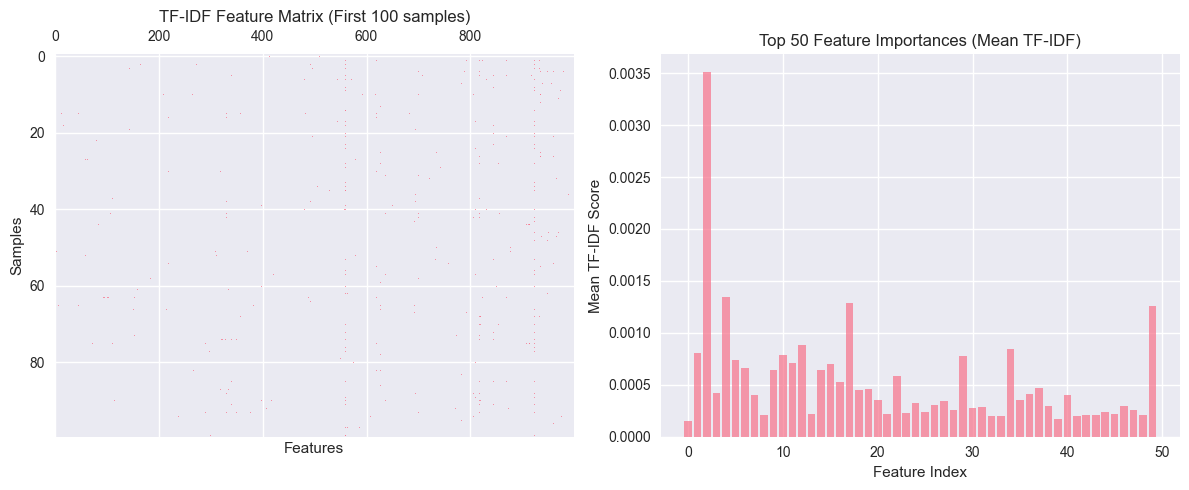

In [10]:
# Load and preprocess the dataset
file_path = '../data/LVDAndro_APKs_downsampled.csv'
balanced_df = pd.read_csv(file_path, low_memory=False)
balanced_df = balanced_df.dropna(subset=['processed_code']).copy()


# Extract TF-IDF features
print("Extracting TF-IDF features...")
X_tfidf = preprocessor.extract_tfidf_features(balanced_df['processed_code'])

# Prepare sequences
print("\nPreparing text sequences...")
X_sequences = preprocessor.prepare_sequences(balanced_df['processed_code'])

# Get target variable
y = balanced_df['Vulnerability_status'].values

print("\nFeature Extraction Summary:")
print(f"TF-IDF features shape: {X_tfidf.shape}")
print(f"Sequence features shape: {X_sequences.shape}")
print(f"Target variable shape: {y.shape}")

# Visualize TF-IDF feature matrix
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
# Plot sparse matrix pattern
plt.spy(X_tfidf[:100, :], markersize=0.5, aspect='auto')
plt.title('TF-IDF Feature Matrix (First 100 samples)')
plt.xlabel('Features')
plt.ylabel('Samples')

plt.subplot(1, 2, 2)
# Plot feature importance (mean TF-IDF scores)
feature_importance = np.mean(X_tfidf, axis=0)
plt.bar(range(len(feature_importance[:50])), feature_importance[:50], alpha=0.7)
plt.title('Top 50 Feature Importances (Mean TF-IDF)')
plt.xlabel('Feature Index')
plt.ylabel('Mean TF-IDF Score')

plt.tight_layout()
plt.show()

## 5. Sequence Analysis

Vocabulary size: 126887
Number of words used: 10000

Top 20 most common words:
  <OOV>: 1
  s: 2
  r: 3
  user: 4
  his: 5
  log: 6
  g: 7
  e: 8
  i: 9
  ri: 10
  ge: 11
  a: 12
  d: 13
  ex: 14
  field: 15
  io: 16
  ag: 17
  fi: 18
  al: 19
  me: 20


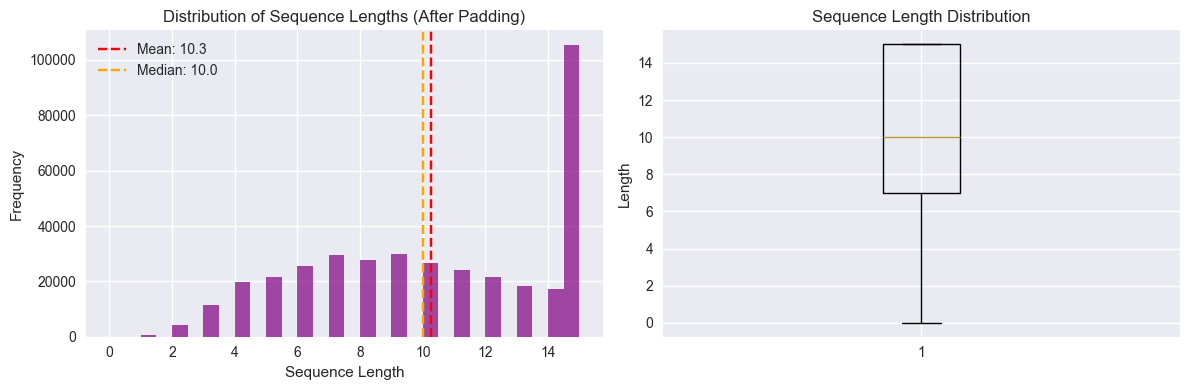


Sequence Length Statistics:
Mean sequence length: 10.26
Median sequence length: 10.00
Standard deviation: 3.99
Maximum sequence length: 15
Minimum sequence length: 0
Percentage of zero sequences: 0.00%


In [11]:
# Analyze vocabulary
word_index = preprocessor.tokenizer.word_index
print(f"Vocabulary size: {len(word_index)}")
print(f"Number of words used: {preprocessor.tokenizer.num_words}")

# Show most common words
word_counts = sorted(word_index.items(), key=lambda x: x[1])[:20]
print("\nTop 20 most common words:")
for word, index in word_counts:
    print(f"  {word}: {index}")

# Analyze sequence lengths after padding
sequence_lengths = np.sum(X_sequences != 0, axis=1)

plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.hist(sequence_lengths, bins=30, alpha=0.7, color='purple')
plt.axvline(sequence_lengths.mean(), color='red', linestyle='--', label=f'Mean: {sequence_lengths.mean():.1f}')
plt.axvline(np.median(sequence_lengths), color='orange', linestyle='--', label=f'Median: {np.median(sequence_lengths):.1f}')
plt.title('Distribution of Sequence Lengths (After Padding)')
plt.xlabel('Sequence Length')
plt.ylabel('Frequency')
plt.legend()

plt.subplot(1, 2, 2)
plt.boxplot(sequence_lengths)
plt.title('Sequence Length Distribution')
plt.ylabel('Length')

plt.tight_layout()
plt.show()

print(f"\nSequence Length Statistics:")
print(f"Mean sequence length: {sequence_lengths.mean():.2f}")
print(f"Median sequence length: {np.median(sequence_lengths):.2f}")
print(f"Standard deviation: {sequence_lengths.std():.2f}")
print(f"Maximum sequence length: {sequence_lengths.max()}")
print(f"Minimum sequence length: {sequence_lengths.min()}")
print(f"Percentage of zero sequences: {(sequence_lengths == 0).sum() / len(sequence_lengths) * 100:.2f}%")

## 6. Save Preprocessed Data

In [12]:
# Save preprocessed features for model training
import pickle

preprocessed_data = {
    'X_tfidf': X_tfidf,
    'X_sequences': X_sequences,
    'y': y,
    'feature_names': preprocessor.tfidf_vectorizer.get_feature_names_out(),
    'word_index': preprocessor.tokenizer.word_index
}

with open('../data/preprocessed_data.pkl', 'wb') as f:
    pickle.dump(preprocessed_data, f)

print("Preprocessed data saved to '../data/preprocessed_data.pkl'")
print("\nData preprocessing completed successfully!")
print("\nNext steps:")
print("1. Run 02_model_training.ipynb to train the models")
print("2. Run 03_results_analysis.ipynb to analyze the results")

Preprocessed data saved to '../data/preprocessed_data.pkl'

Data preprocessing completed successfully!

Next steps:
1. Run 02_model_training.ipynb to train the models
2. Run 03_results_analysis.ipynb to analyze the results
